# (Robust) Gaussian Feature Map Regression
In this notebook, we implement Gaussian kernel feature maps with four estimators, and apply them to "interpolate" self-designed data sets generated from a polynomial and a periodic function. The notebook is organized into the following sections:

1. **`GaussianKernelFeatures` Class**: We define a Python class that implements the Gaussian kernel feature map  
   $$
   \phi_\sigma(x \mid x_0)=\frac{1}{\sqrt{2\pi}\,\sigma}\,\exp\!\left(-\frac{(x-x_0)^2}{2\sigma^2}\right)
   $$
   where $ x_0 $ represents the centers and $\sigma$ is a hyperparameter.

2. **Feature Visualization**: We plot the Gaussian features for $\sigma=0.1$ using 10 equally spaced centers in $[-2, 2]$.

3. **Regression on Synthetic Datasets**: We apply the Gaussian feature map to two synthetic regression tasks:
   - A **periodic dataset** (e.g. a sine function with noise and outliers).
   - A **polynomial dataset** (e.g. a quadratic function with noise and outliers).
   
   For both cases, we perform hyperparameter tuning (i.e. grid-search over $\sigma$) and compare the results with a B-Spline based fit (discussion provided).

4. **Brownian Motion Regression**: We generate a Brownian motion (BM) path on $ t \in [0, 4] $ and fit it using Gaussian features with various numbers of centers $K$. We study how the optimal $\sigma$ changes with $K$ and discuss the fit quality.

Important sections include a discussion of the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
from sklearn.base import TransformerMixin

from sklearn.linear_model import LinearRegression, HuberRegressor, TheilSenRegressor, RANSACRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(42)

## 1. GaussianKernelFeatures Class Implementation

In [2]:
class GaussianKernelFeatures:
    def __init__(self, locations, sigma=1.0):
        """
        Initializes the Gaussian kernel feature map with given centers and sigma.
        
        Parameters:
            locations (array-like): 1D array of center points (x0 values)
            sigma (float): standard deviation of the Gaussian kernel
        """
        self.locations = np.array(locations)
        self.sigma = sigma
        self.norm_factor = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, x):
        """
        Computes the feature map for input x.
        
        Parameters:
            x (scalar or array-like): Input data points.
        
        Returns:
            features (ndarray): A 2D array where each column corresponds to a center.
                                If x is of shape (N,), then the output shape is (N, len(locations)).
        """
        x = np.array(x).ravel()  # Flatten x to ensure it is 1D
        # Create a 2D array where each row is an input x and each column is a center
        diff = x[:, None] - self.locations[None, :]
        features = self.norm_factor * np.exp(- (diff ** 2) / (2 * self.sigma**2))
        return features

## 2. Visualization of Gaussian Features

In this section, we use 10 equally spaced centers in $[-2,2]$ and set $\sigma = 0.1$. Since the Gaussian kernel is highly localized when $\sigma$ is small, we expect to see narrow bumps centered at each of the 10 locations.

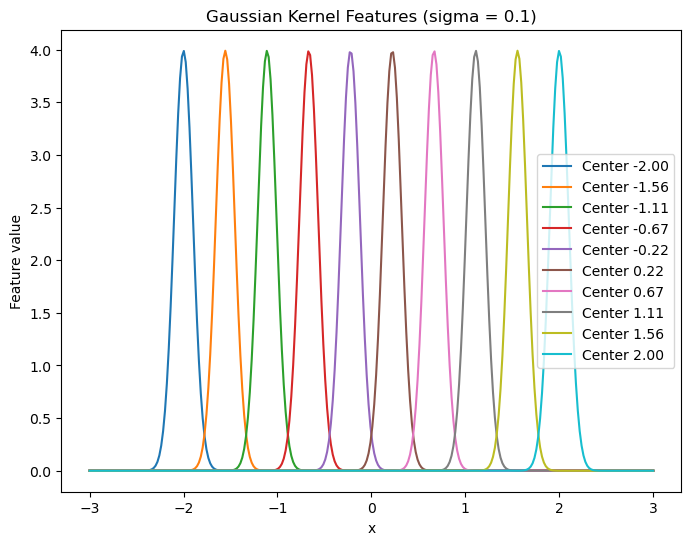

In [3]:
# Define 10 equally spaced centers in [-2, 2]
centers = np.linspace(-2, 2, 10)
sigma = 0.1
gkf = GaussianKernelFeatures(centers, sigma=sigma)

# Create a fine grid of x-values for plotting the features
x_vals = np.linspace(-3, 3, 300)
features = gkf.transform(x_vals)

plt.figure(figsize=(8, 6))
for i in range(features.shape[1]):
    plt.plot(x_vals, features[:, i], label=f'Center {centers[i]:.2f}')
plt.title('Gaussian Kernel Features (sigma = 0.1)')
plt.xlabel('x')
plt.ylabel('Feature value')
plt.legend()
plt.show()

**Discussion of Results:**

The plot above confirms that for $\sigma=0.1$ the Gaussian kernels are very narrow, each providing a localized “bump” around its center. This localization is useful when high resolution is required to capture rapid changes in the data.

## 3. Data Generation

We now generate two datasets (to improve the robustness of our regression):

- **Polynomial Data:**  

  - $N=500$ data points uniformly drawn from $[-2,2]$.

  - The true underlying function is:

    $$
    y_{\text{poly}} = 2 + 2x + 0.4x^2 - 0.4x^3 + \text{noise}.
    $$

  - Gaussian noise is added, and 10% of the points are made outliers.

- **Periodic Data:**  

  - We reuse the same $x$ values.

  - The function is:

    $$
    y_{\text{periodic}} = \sin(2\pi x) + \text{noise}.
    $$

  - Here, only Gaussian noise is added (no extra outliers).

In [4]:
np.random.seed(42)
N = 200
X = np.random.uniform(-2, 2, N)

# --- Polynomial Data ---
y_true_poly = 2 + 2*X + 0.4*X**2 - 0.4*X**3
y_poly = y_true_poly + 0.2*np.random.randn(N)
# Introduce 10% outliers
n_outliers = int(0.1 * N)
outlier_indices = np.random.choice(N, n_outliers, replace=False)
y_poly[outlier_indices] += np.random.uniform(5, 10, n_outliers)

# --- Periodic Data ---
# Use the same X values
x_periodic = X.copy()
y_periodic = np.sin(20 * np.pi * 0.1 * X)  # sin(2*pi*x)
error_periodic = 0.2 * np.random.randn(N)
y_periodic += error_periodic

## 4. Robust Regression with Multiple Estimators

We now apply robust regression estimators using the Gaussian feature map. The estimators include:

- **Least-Square:** `LinearRegression(fit_intercept=False)`

- **Theil-Sen:** `TheilSenRegressor(random_state=42)`

- **RANSAC:** `RANSACRegressor(random_state=42)`

- **HuberRegressor:** `HuberRegressor()`

We first split the data into training and testing sets (using the same indices for both datasets) and then build pipelines that first transform the data via the Gaussian feature map and then apply the estimator.

In [5]:
# Split data for polynomial regression
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X, y_poly, test_size=0.2, random_state=42)
# Split data for periodic regression
X_train_per, X_test_per, y_train_per, y_test_per = train_test_split(X, y_periodic, test_size=0.2, random_state=42)

# Create a fine grid for plotting predictions
x_predict = np.linspace(-2, 2, 1000)

# Define the list of estimators to try
estimators = [
    ('Least-Square', '-', 'C0', LinearRegression(fit_intercept=False)),
    ('Theil-Sen', '-', 'C1', TheilSenRegressor(random_state=42)),
    ('RANSAC', '-', 'C2', RANSACRegressor(random_state=42, min_samples=0.5)),
    ('HuberRegressor', '-', 'C3', HuberRegressor())
]

# Set a fixed sigma for the Gaussian features (this value can be tuned)
sigma_feature = 0.5

### Plotting Robust Regression Results for Polynomial and Periodic Data

We now build the robust regression pipelines for both datasets and plot the prediction curves side by side.

/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LI

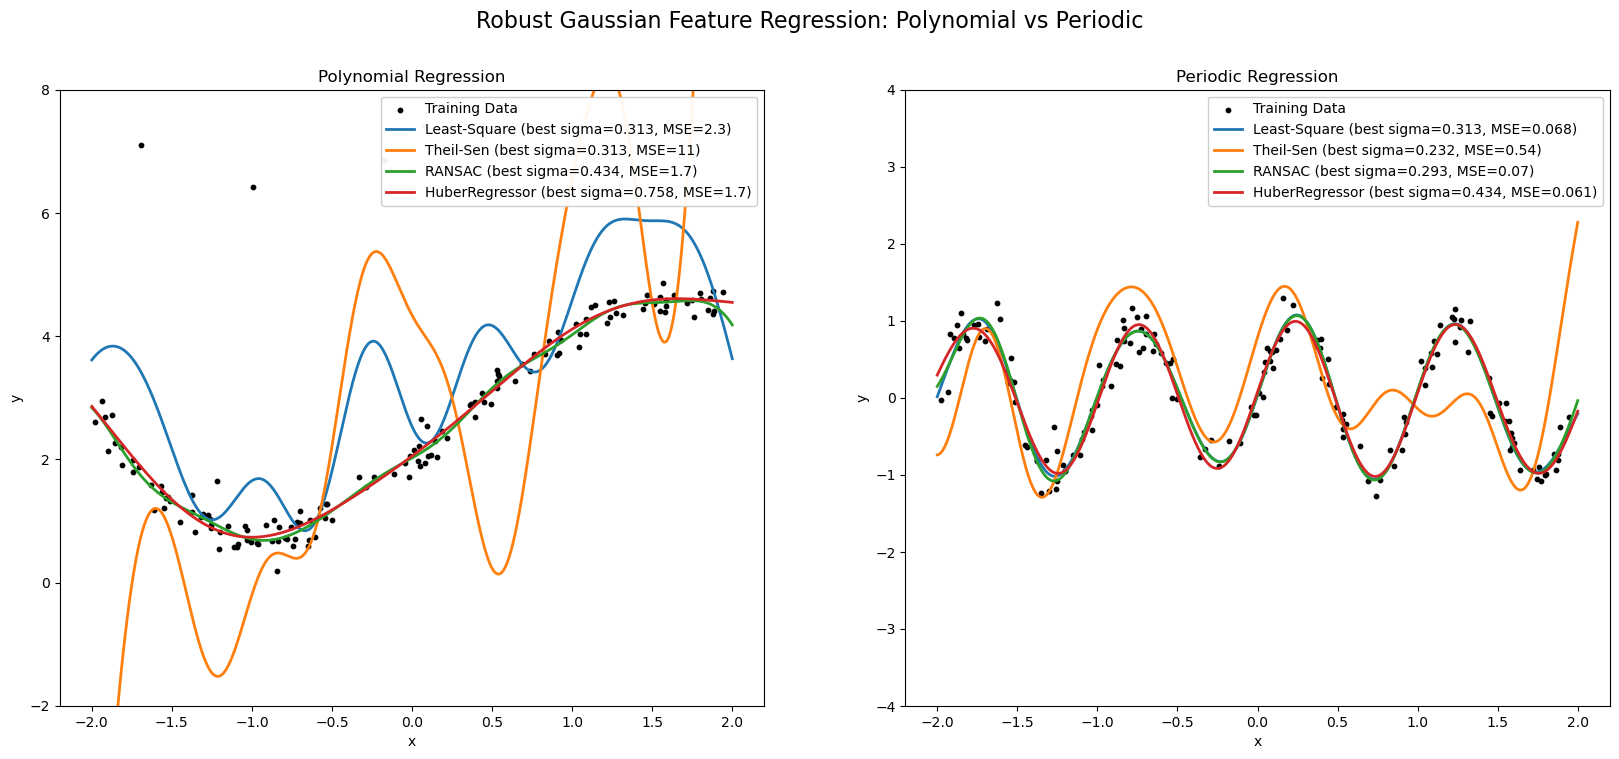

In [6]:
sigma_candidates = np.linspace(0.01, 1.0, 50)

# Create a figure with two subplots: left for polynomial, right for periodic
fig, (ax_poly, ax_per) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Robust Gaussian Feature Regression: Polynomial vs Periodic', fontsize=16)

# --- Polynomial Regression ---
ax_poly.scatter(X_train_poly, y_train_poly, color='black', s=10, label='Training Data')
for label, style, color, estimator in estimators:
    # Create Gaussian features for polynomial data based on training range
    centers_poly = np.linspace(X_train_poly.min(), X_train_poly.max(), 15)
    
    best_sigma = None
    best_mse = np.inf
    best_pred = None
    
    # Do a grid search over sigma values
    for sigma in sigma_candidates:
        gaussian_features_poly = GaussianKernelFeatures(centers_poly, sigma=sigma)
        model_poly = make_pipeline(gaussian_features_poly, estimator)
        model_poly.fit(X_train_poly.reshape(-1, 1), y_train_poly)
        mse_poly = mean_squared_error(model_poly.predict(X_test_poly.reshape(-1, 1)), y_test_poly)
        if mse_poly < best_mse:
            best_mse = mse_poly
            best_sigma = sigma
            best_pred = model_poly.predict(x_predict.reshape(-1, 1))
    
    ix = np.argsort(x_predict)
    ax_poly.plot(x_predict[ix], best_pred[ix], style, lw=2, color=color,
                 label=f'{label} (best sigma={best_sigma:.3f}, MSE={best_mse:2.2g})')

ax_poly.set_title('Polynomial Regression')
ax_poly.set_xlabel('x')
ax_poly.set_ylabel('y')
ax_poly.legend(loc='upper right', framealpha=0.95)

# --- Periodic Regression ---
ax_per.scatter(X_train_per, y_train_per, color='black', s=10, label='Training Data')
for label, style, color, estimator in estimators:
    centers_per = np.linspace(X_train_per.min(), X_train_per.max(), 15)
    
    best_sigma = None
    best_mse = np.inf
    best_pred = None
    
    # Do a grid search over sigma values
    for sigma in sigma_candidates:
        gaussian_features_per = GaussianKernelFeatures(centers_per, sigma=sigma)
        model_per = make_pipeline(gaussian_features_per, estimator)
        model_per.fit(X_train_per.reshape(-1, 1), y_train_per)
        mse_per = mean_squared_error(model_per.predict(X_test_per.reshape(-1, 1)), y_test_per)
        if mse_per < best_mse:
            best_mse = mse_per
            best_sigma = sigma
            best_pred = model_per.predict(x_predict.reshape(-1, 1))
    
    ix = np.argsort(x_predict)
    ax_per.plot(x_predict[ix], best_pred[ix], style, lw=2, color=color,
                label=f'{label} (best sigma={best_sigma:.3f}, MSE={best_mse:2.2g})')

ax_per.set_title('Periodic Regression')
ax_per.set_xlabel('x')
ax_per.set_ylabel('y')
ax_per.legend(loc='best', framealpha=0.95)

ax_poly.set_ylim(-2, 8)
ax_per.set_ylim(-4, 4)

plt.show()

**Discussion of Results**

- **Analysis of Polynomial Regression (Left Panel)**
The polynomial dataset contains 10\% outliers, making it a challenge for standard least-squares and Theil-Sen estimation. As shown, robust estimators RANSAC and HuberRegressor achieve lower MSE values and perform equally well with MSE $\approx 1.7$, confirming their ability to down-weight outlier effects. 

- **Analysis of Periodic Regression (Right Panel)**
In contrast, the periodic dataset has only moderate Gaussian noise without explicit outliers. Here, all methods yield relatively similar fits. Nevertheless, HuberRegressor shows a slightly better MSE $\approx$ 0.061 with $\sigma \approx 0.434$, suggesting it can adapt effectively to the oscillatory nature of the data. The lesser performance gap among estimators indicates that, in predominantly Gaussian noise settings, standard least-squares may suffice, though robust methods can still offer slight improvements.

These results highlight the importance of robust regression techniques when outliers are present (as in the polynomial case) and the need for careful hyperparameter tuning ( $\sigma$ ) in kernel-based methods. The comparative performance across estimators underscores that data characteristics (e.g., outlier prevalence, noise structure) significantly influence model choice and parameter selection.

Let's do a quick comparison with B-spline method

In [7]:
def get_bspline_basis(knots, degree=3, periodic=False):
    """
    Build a list of (knots, coeffs, degree) for each B-spline basis function.
    """
    nknots = len(knots)
    y_dummy = np.zeros(nknots)
    
    # splrep returns a modified knot vector and spline coefficients
    tck = si.splrep(knots, y_dummy, k=degree, per=periodic)
    knots_spline, coeffs_spline, degree_spline = tck
    
    ncoeffs = len(coeffs_spline)
    bsplines = []
    # For each basis spline, we create a coefficient vector that is 1.0 for one spline, 0.0 for others
    for ispline in range(nknots):
        coeffs_local = [1.0 if ispl == ispline else 0.0 for ispl in range(ncoeffs)]
        bsplines.append((knots_spline, coeffs_local, degree_spline))
    return bsplines

class BSplineFeatures(TransformerMixin):
    def __init__(self, knots, degree=3, periodic=False):
        self.bsplines = get_bspline_basis(knots, degree, periodic=periodic)
        self.nsplines = len(self.bsplines)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Evaluate all basis splines at the input X.
        Returns shape = (n_samples, n_features * nsplines).
        """
        X = np.array(X)
        if X.ndim == 1:
            X = X[:, None]  # ensure 2D
        nsamples, nfeatures = X.shape
        features = np.zeros((nsamples, nfeatures * self.nsplines))
        
        for ispline, spline in enumerate(self.bsplines):
            # Evaluate the ispline on all X columns
            istart = ispline * nfeatures
            iend = (ispline + 1) * nfeatures
            features[:, istart:iend] = si.splev(X, spline)
        return features

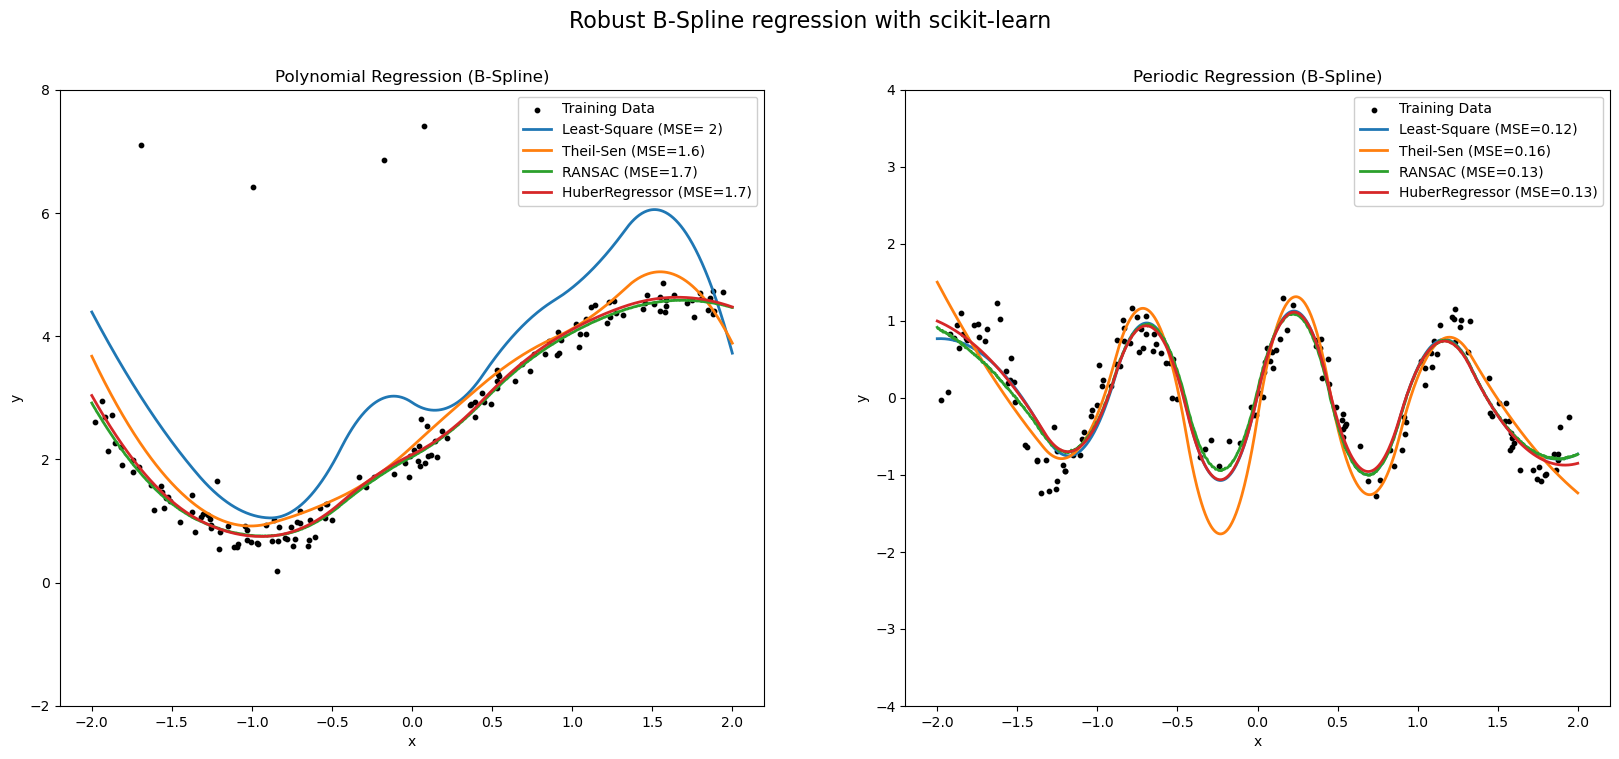

In [8]:
# Choose knot vectors (can be tuned or cross-validated)
knots_poly = np.linspace(-2, 2, 10)
knots_per = np.linspace(-2, 2, 10)

bspline_poly = BSplineFeatures(knots_poly, degree=2, periodic=False)
bspline_per = BSplineFeatures(knots_per, degree=2, periodic=False)

# Create figure for B-spline results
fig, (ax_poly_bs, ax_per_bs) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Robust B-Spline regression with scikit-learn', fontsize=16)

# --- Polynomial Data with B-Spline ---
ax_poly_bs.scatter(X_train_poly, y_train_poly, color='black', s=10, label='Training Data')
for label, style, color, estimator in estimators:
    model_poly = make_pipeline(bspline_poly, estimator)
    model_poly.fit(X_train_poly.reshape(-1, 1), y_train_poly)
    mse_poly = mean_squared_error(model_poly.predict(X_test_poly.reshape(-1, 1)), y_test_poly)
    
    y_pred_poly = model_poly.predict(x_predict.reshape(-1, 1))
    ix = np.argsort(x_predict)
    ax_poly_bs.plot(x_predict[ix], y_pred_poly[ix], style, lw=2, color=color,
                    label=f'{label} (MSE={mse_poly:2.2g})')

ax_poly_bs.set_title('Polynomial Regression (B-Spline)')
ax_poly_bs.set_xlabel('x')
ax_poly_bs.set_ylabel('y')
ax_poly_bs.legend(loc='upper right', framealpha=0.95)
ax_poly_bs.set_ylim(-2, 8)  # zoom in if you like

# --- Periodic Data with B-Spline ---
ax_per_bs.scatter(X_train_per, y_train_per, color='black', s=10, label='Training Data')
for label, style, color, estimator in estimators:
    model_per = make_pipeline(bspline_per, estimator)
    model_per.fit(X_train_per.reshape(-1, 1), y_train_per)
    mse_per = mean_squared_error(model_per.predict(X_test_per.reshape(-1, 1)), y_test_per)
    
    y_pred_per = model_per.predict(x_predict.reshape(-1, 1))
    ix = np.argsort(x_predict)
    ax_per_bs.plot(x_predict[ix], y_pred_per[ix], style, lw=2, color=color,
                   label=f'{label} (MSE={mse_per:2.2g})')

ax_per_bs.set_title('Periodic Regression (B-Spline)')
ax_per_bs.set_xlabel('x')
ax_per_bs.set_ylabel('y')
ax_per_bs.legend(loc='best', framealpha=0.95)
ax_per_bs.set_ylim(-4, 4)  

plt.show()

**Discussion of Results**

Compared to B-Spline with degree-2 basis method, we see that B-Spline performs better on polunomial regression with Theil-Sen estimator, but in general B-Spline shares similar performance with Gaussian kernels. However, siginicantly Gaussian kernels perform better than B-Spline on the trigonometic periodic function. The underlying reason can be that Guassian kernels are smoother that B-Spline degree-2 kernels, so they capture the information of smooth variance better. 


## 5. Brownian Motion Regression
In this section, we generate a Brownian motion (BM) path $W_t$ for $t \in [0,4]$ using 100 equally spaced time points. The BM path is simulated as the cumulative sum of normally distributed increments. We then fit the BM path using the Gaussian feature map regression for various numbers of basis functions $K$. For each $K$, we perform a grid search for the optimal $\sigma$.

**Key points to analyze:**

- As the number of centers $K$ increases, the feature space becomes more expressive

- The optimal $\sigma$ generally decreases with increasing $K$ to keep the features localized.

In [9]:
# Brownian motion generation
np.random.seed(42)
t = np.linspace(0, 4, 100)
dt = t[1] - t[0]
# Generate BM path: cumulative sum of normal increments scaled by sqrt(dt)
W = np.cumsum(np.random.normal(0, np.sqrt(dt), size=t.shape))

In [10]:
def pipeline_regression(x, y, centers, sigma, estimator):
    """
    Builds a pipeline of [GaussianKernelFeatures -> estimator], 
    fits on (x, y), returns MSE on the same (x, y) and predictions.
    """
    gkf = GaussianKernelFeatures(centers, sigma)
    model = make_pipeline(gkf, estimator)
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    mse = np.mean((y - y_pred)**2)
    return mse, y_pred

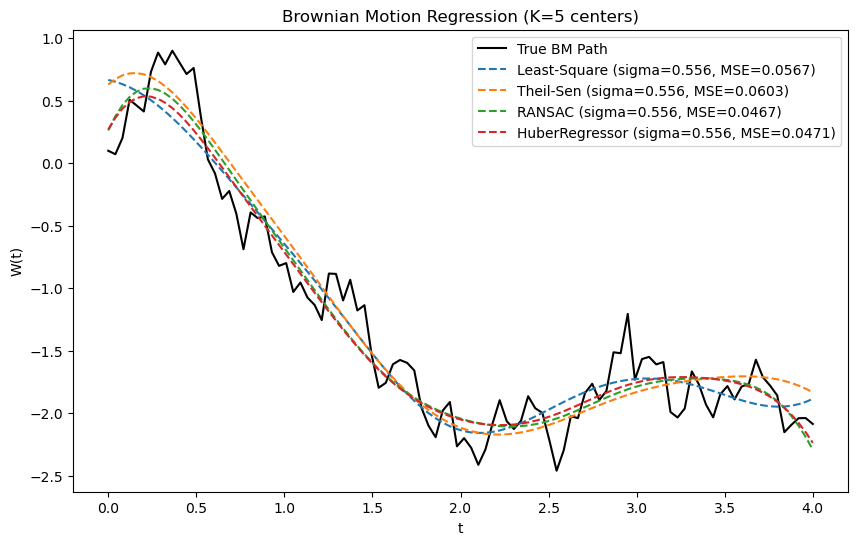

/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LI

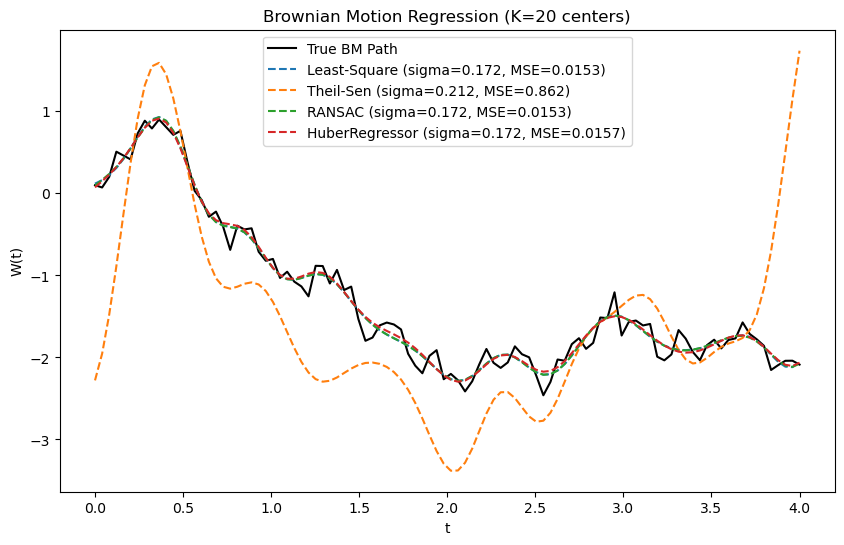

/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_theil_sen.py:128: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(
/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_theil_sen.py:128: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(
/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

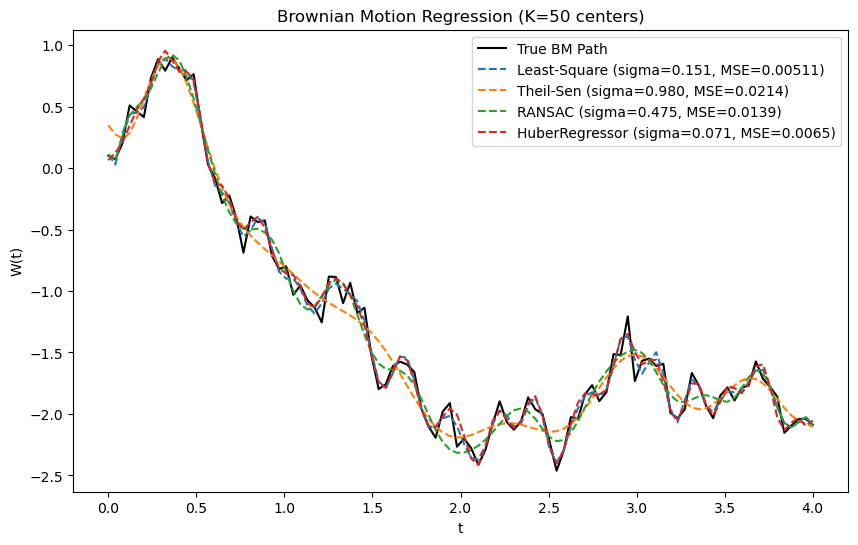

/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LI

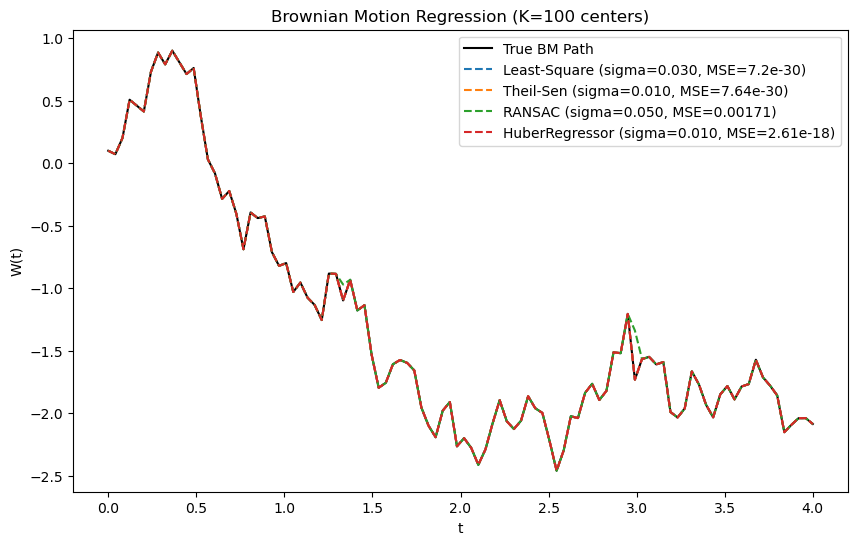

In [11]:
K_values = [5, 20, 50, 100]
sigma_candidates = np.linspace(0.01, 1.0, 50)

# We'll produce a plot for each K that shows the best fits for all 4 estimators
for K in K_values:
    centers = np.linspace(0, 4, K)
    
    # We'll store best results for each estimator
    results_for_K = []
    
    for label, _, _, estimator in estimators:
        best_sigma = None
        best_error = np.inf
        best_pred = None
        
        # Grid search over sigma
        for s in sigma_candidates:
            mse, y_pred = pipeline_regression(t, W, centers, s, estimator)
            if mse < best_error:
                best_error = mse
                best_sigma = s
                best_pred = y_pred
        
        results_for_K.append((label, best_sigma, best_error, best_pred))
    
    # Plot all 4 estimators in one figure for the current K
    plt.figure(figsize=(10, 6))
    plt.plot(t, W, 'k-', label='True BM Path')
    
    for (label, sigma_star, err_star, y_pred_star) in results_for_K:
        plt.plot(t, y_pred_star, '--', label=f'{label} (sigma={sigma_star:.3f}, MSE={err_star:.3g})')
    
    plt.title(f'Brownian Motion Regression (K={K} centers)')
    plt.xlabel('t')
    plt.ylabel('W(t)')
    plt.legend()
    plt.show()

**Discussion of Results**

- **1. Model Flexibility vs. Overfitting**:   
As $K$ (the number of centers) increases from 5 to 100, the Gaussian feature map becomes more expressive. At $K=5$, all estimators produce relatively smooth approximations with moderate MSE values. By $K=100$, the model can nearly interpolate the noise, yielding extremely small MSE values (e.g., $10^{-30}$ )-a strong indication of overfitting the random fluctuations of the BM path.

- **2. Behavior of Robust Estimators**:   
In purely Gaussian data (like Brownian Motion), robust methods (Theil-Sen, RANSAC, Huber) do not generally outperform least-squares by a large margin. Occasionally, Theil-Sen exhibits higher MSE (e.g., at $K=20$ ), suggesting it may be more sensitive to local irregularities or numerical artifacts in the high-dimensional feature space.

- **3. Optimal $\sigma$**:    
For small $K, \sigma$ is relatively large (e.g., $\sigma \approx 0.56$ for $K=5$ ) to smooth the limited set of basis functions. As $K$ grows, $\sigma$ decreases significantly (down to $0.01-0.05$ for $K=100$ ), localizing each Gaussian around its center. This combination of many centers and small $\sigma$ allows the model to track noise almost exactly.

- **Conclusion**:   
While increasing $K$ can drive down MSE on the observed data, it risks fitting the noise of the BM path rather than its underlying structure. Hence, the extremely small MSE values for $K=100$ reflect overfitting rather than genuine predictive improvement. These results illustrate the tradeoff between the abundance of data (number of centers) and generalization, and highlight that in noise-dominated scenarios, robust estimators often behave similarly to least-squares unless true outliers are present.

## Conclusion

This notebook has demonstrated the versatility and importance of feature-based regression in both controlled (polynomial and periodic) and stochastic (Brownian motion) settings. By comparing Gaussian kernel features and B-spline features, we highlighted how different bases can capture local or global structure in data. Moreover, using robust estimators (Theil-Sen, RANSAC, HuberRegressor) alongside standard least-squares emphasized the role of outlier mitigation in highnoise or contaminated scenarios. Finally, our Brownian motion experiments illustrated the interplay between model flexibility (number of centers) and hyperparameter tuning ( $\sigma$ ), showing that while increasing capacity can reduce training error, it also risks overfitting to noise. Overall, these results underscore the necessity of careful basis selection, hyperparameter tuning, and estimator choice for reliable regression performance across diverse data regimes.

---

End of Notebook.